In [118]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from keijzer_exogan import *

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
#sns.set()

Random Seed:  999


In [119]:
torch.cuda.device_count()

4

In [120]:
# Root directory for dataset
dataroot = "/datc/opschaler/brian/celeba_complete"

# Number of workers for dataloader
workers = 0 # 0 when to_vram is enabled

# Batch size during training
batch_size = 1 # 2**11
print('Batch size: ', batch_size)

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 1 

# Learning rate for optimizers
lr = 1e-5
lr_G = 2e-4

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
selected_gpus = [0]
ngpu = len(selected_gpus)

Batch size:  1


## Mark the below cell as code to use the celeba dataset

## Mark the below cell as code to use the ExoGAN dataset

In [121]:
pwd

'/home/16011015/notebooks/SRON-DCGAN/notebooks'

In [122]:
##### Creating custom Dataset classes
path = '/datb/16011015/ExoGAN_data/selection//' #notice how you dont put the last folder in here...
images = np.load(path+'first_chunks_25_percent_images.npy')

shuffle = True

if shuffle:
    np.random.shuffle(images) # shuffles the images

images = images[:1] # select the first image, lateron this has to change to is load a 'selected' image to inpaint (instead of working from this excisting dataset)
print('Number of images: ', len(images))

dataset = numpy_dataset(data=images, to_vram=True) # to_vram pins it to all GPU's
#dataset = numpy_dataset(data=images, to_vram=True, transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # to_vram pins it to all GPU's

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=False)

Number of images:  1


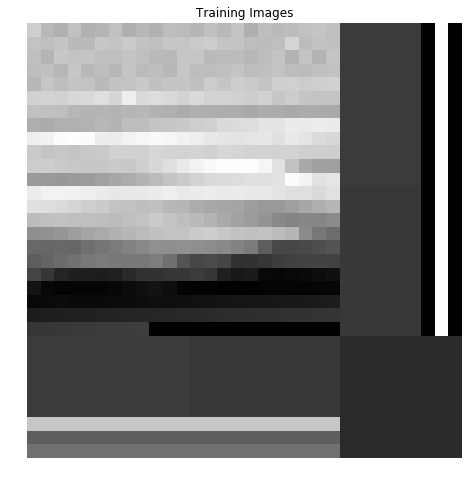

In [123]:
# Decide which device we want to run on
# Seems to be the main devive, e.g. cuda:0 wont work when only gpu [2,3] are selected... is [2,3] then do cuda:2
device = torch.device("cuda:"+str(selected_gpus[0]) if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [124]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [125]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        """
        where (in_channels, out_channels, 
        kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
        """
        self.main = nn.Sequential(
            
            #1
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            #4
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Dropout2d(0.5),
            
            #7
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Dropout2d(0.5),
            
            #10
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf*1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*1),
            nn.ReLU(True),
            
            # Go from 1x64x64 to 1x32x32
            nn.Conv2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*1),
            nn.ReLU(True),
                        #10
            # state size. (ngf*2) x 16 x 16
            #nn.ConvTranspose2d( ngf * 2, ngf*1, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ngf*1),
            #nn.ReLU(True),
            
            #13
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf*1, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [126]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, device_ids=selected_gpus, output_device=device) # select only gpu 0, 2, 3

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Dropout2d(p=0.5)
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Dropout2d(p=0.5)
    (11): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


In [127]:
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Dropout2d(p=0.5)
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Dropout2d(p=0.5)
    (11): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


In [128]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 1, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 1, ndf * 2, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [129]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    print('netD to cuda')
    netD = nn.DataParallel(netD, device_ids=selected_gpus, output_device=device) # select only gpu 0, 2, 3

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace)
    (10): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): Sigmoid()
  )
)


In [130]:
from torchsummary import summary
summary(netD, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             512
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]          16,384
         LeakyReLU-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          32,768
         LeakyReLU-6             [-1, 64, 4, 4]               0
            Conv2d-7            [-1, 128, 2, 2]         131,072
         LeakyReLU-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 1, 1]         524,288
        LeakyReLU-10            [-1, 256, 1, 1]               0
           Conv2d-11              [-1, 1, 1, 1]             256
          Sigmoid-12              [-1, 1, 1, 1]               0
Total params: 705,280
Trainable params: 705,280
Non-trainable params: 0
-------------------------------

In [131]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # should be sgd
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

In [132]:
import time as t

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

In [133]:
train_D = True
train_G = True

In [134]:
from IPython.display import clear_output

In [135]:
# Load saved weights
netG.load_state_dict(torch.load('netG_state_dict', map_location=device)) #net.module..load_... for parallel model , net.load_... for single gpu model
netD.load_state_dict(torch.load('netD_state_dict', map_location=device))

In [ ]:
from torchsummary import summary
summary(netG, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
         Dropout2d-7            [-1, 128, 8, 8]               0
   ConvTranspose2d-8           [-1, 64, 16, 16]         131,072
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
        Dropout2d-11           [-1, 64, 16, 16]               0
  ConvTranspose2d-12           [-1, 32, 32, 32]          32,768
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,

In [ ]:
netD.parameters

<bound method Module.parameters of Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): LeakyReLU(negative_slope=0.2, inplace)
    (10): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): Sigmoid()
  )
)>

In [ ]:
summary(netD, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             512
         LeakyReLU-2           [-1, 32, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]          16,384
         LeakyReLU-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          32,768
         LeakyReLU-6             [-1, 64, 4, 4]               0
            Conv2d-7            [-1, 128, 2, 2]         131,072
         LeakyReLU-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 1, 1]         524,288
        LeakyReLU-10            [-1, 256, 1, 1]               0
           Conv2d-11              [-1, 1, 1, 1]             256
          Sigmoid-12              [-1, 1, 1, 1]               0
Total params: 705,280
Trainable params: 705,280
Non-trainable params: 0
-------------------------------

# Inpainting
TODO: Implement the following

The corrupted image $y$ is mapped to the closest $z$ in the latent representation space, this mapping is denoted as $\hat{z}$.
    
$\hat{z} = \operatorname{arg\,min}_z \{ \mathcal{L}_c(z |y, M) + \mathcal{L}_p (z) \}$

where

$\mathcal{L}_c(z |y, M) = || M \bigodot G(z) - M \bigodot y||_1 = || M \bigodot (G(z)-y) ||_1 $

with $c$ being contextual loss and $M$ being a binary mask with the same size as $y$,

$\mathcal{L}_p (z) = \lambda \operatorname{log}(1-D(G(z)))$

with $p$ being perceptual loss and $D$ being the discriminator.

Once $G(\hat{z})$ is generated, the final solution $\hat{x}$ is calculated as

$\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$  

(substitute $x_i = y_i$ for $M_i = 1$).

-----

$|| ... ||$ is done by `torch.norm()`.  
$... \bigodot ...$ is done by `torch.mul()`.  

In [ ]:
# (re)define variables (for clarity)

G = netG
D = netD
z = torch.randn(1, nz, 1, 1, requires_grad=True, device=device)

lamb = 3e-3

criteria = nn.BCELoss()

z.shape

torch.Size([1, 100, 1, 1])

In [ ]:
n_iters = 1*10**3 # number of iters to do for inpainting

In [ ]:
real_images = []
masked_images= []
inpainted_images = []

data.shape:  torch.Size([1, 1, 32, 32])
image.shape:  torch.Size([1, 1, 32, 32])
mask.shape torch.Size([1, 1, 32, 32])
masked image shape torch.Size([1, 1, 32, 32])
 iteration :  999 , context_loss: 235.1906, perceptual_loss: -0.875369, total_loss: 235.187958

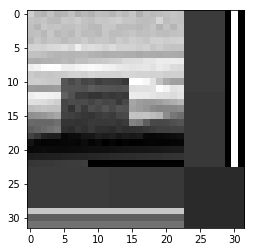

In [ ]:
for i, data in enumerate(dataloader, 0): # batches per epoch
    real_cpu = data.to(device)
    b_size = real_cpu.size(0) # this is one ofc, it's one image we're trying to inpaint

    print("data.shape: ", data.shape)
    image = data.to(device) # select the image (Channel, Height, Width), this is the original unmasked input image
    real_images.append(image)
    print("image.shape: ", image.shape)

    """Mask the images manually, for testing pruposes"""
    mask = torch.ones(size=image.shape).to(device) # create mask with 1's in the shape of image
    
    print("mask.shape", mask.shape)

    # use a random 'easy' mask
    mask[:, :, 10:20, 5:15] = 0

    masked_image = torch.mul(image, mask).to(device) #image bigodot mask
    masked_images.append(masked_image)
    print('masked image shape', masked_image.shape)
    plt.imshow(masked_image.detach().cpu()[0, 0, :, :], cmap='gray') # plot the masked image

    opt = optim.Adam([z], lr=lr)

    # what's v and m?
    v = torch.tensor(0, dtype=torch.float32, device=device)
    m = torch.tensor(0, dtype=torch.float32, device=device)


    """Start the inpainting process"""
    for iteration in range(n_iters):
        if z.grad is not None:
            z.grad.data.zero_()

        G.zero_grad()
        D.zero_grad()


        image_generated = G(z) # generated image G(z)
        image_generated_masked = torch.mul(image_generated, mask) # G(z) bigodot M
        image_generated_inpainted = torch.mul(image_generated, (1-mask))+masked_image
        
        if (iteration % 10 == 0):
            inpainted_images.append(image_generated_inpainted)

        #print("image_generated_inpainted.shape : ",image_generated_inpainted.shape)

        t = image_generated_inpainted.detach().cpu()[0, 0, :, :]

        # TODO: why does this already look real?
        plt.imshow(t, cmap='gray') # plot the masked image 

        """Calculate losses"""
        loss_context = torch.norm(image_generated_masked-masked_image, p=1) #what's p=1?
        discriminator_output = netD(image_generated_inpainted)
        #print("Discriminator output: ", discriminator_output)

        labels = torch.full((b_size,), 1, device=device)
        loss_perceptual = torch.log(1-discriminator_output)
        
        #print(loss_perceptual.data.cpu().numpy().flatten()[0])

        total_loss = loss_context + lamb*loss_perceptual
        
        # grab the values from losses for printing
        loss_perceptual = loss_perceptual.data.cpu().numpy().flatten()[0]
        loss_context = loss_context.data.cpu().numpy().flatten()[0]



        total_loss.backward()
        opt.step()
        
        total_loss = total_loss.data.cpu().numpy().flatten()[0]
        
        print("\r iteration : {:4} , context_loss: {:.4f}, perceptual_loss: {:4f}, total_loss: {:4f}".format(iteration,loss_context,loss_perceptual, total_loss),end="")


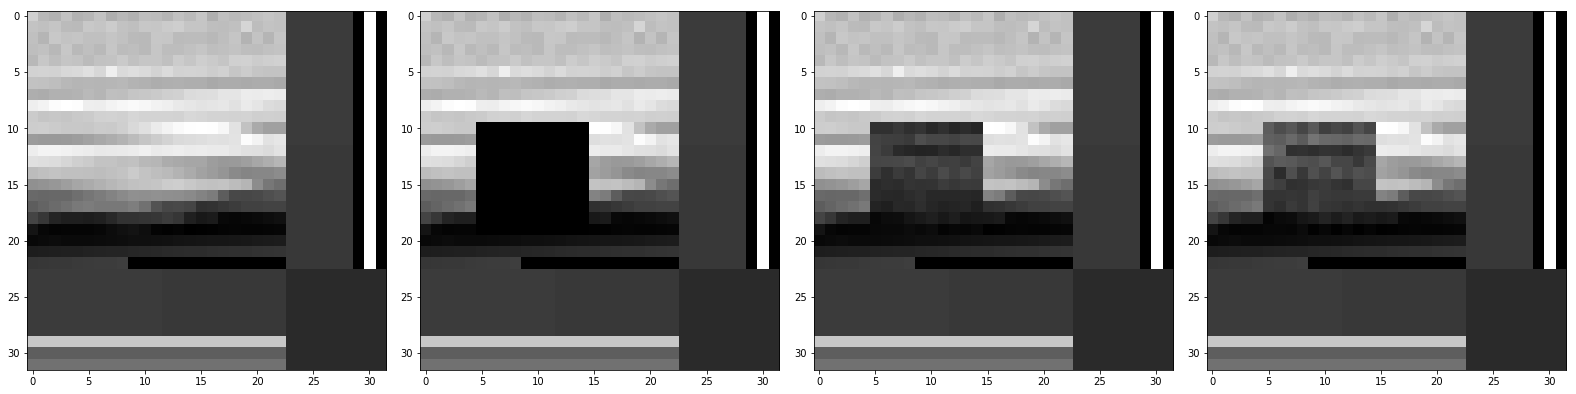

In [ ]:
real = real_images[0].detach().cpu()[0, 0, :, :]
real_masked = masked_images[0].detach().cpu()[0, 0, :, :]

first_generated =inpainted_images[1].detach().cpu()[0, 0, :, :]
last_generated = inpainted_images[-1].detach().cpu()[0, 0, :, :]



plt.figure(figsize=(22,10))

plt.subplot(1,4,1)
plt.imshow(real, cmap='gray')

plt.subplot(1,4,2)
plt.imshow(real_masked, cmap='gray')

plt.subplot(1,4,3)
plt.imshow(first_generated, cmap='gray')

plt.subplot(1,4,4)
plt.imshow(last_generated, cmap='gray')

plt.imshow

plt.tight_layout()

In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 20**128

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i.detach().cpu()[0, 0, :, :], animated=True, cmap='gray')] for i in inpainted_images]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())